### Step 1. 데이터셋 다운과 필요한 라이브러리 import

In [ ]:
!gdown https://drive.google.com/uc?id=1yUgCbRyoBTlcn0TvOUYD0emggN6zSn8M
!unzip -qq seg_dataset.zip

Downloading...
From (original): https://drive.google.com/uc?id=1yUgCbRyoBTlcn0TvOUYD0emggN6zSn8M
From (redirected): https://drive.google.com/uc?id=1yUgCbRyoBTlcn0TvOUYD0emggN6zSn8M&confirm=t&uuid=2a4bf3d1-c2b5-440d-8100-5e265545e011
To: /content/seg_dataset.zip
100% 257M/257M [00:05<00:00, 44.6MB/s]


In [ ]:
!pip install torchsummary torchviz

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4132 sha256=cac090319e7bebe9c73d9cfc685c2586fe209475aba5e7a258f36e8954be1669
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchvision import models, transforms
from torch.utils.data import DataLoader
from torchvision.datasets import VOCSegmentation
import os
from torchviz import make_dot
from torchsummary import summary

### Step 2. U-Net 모델 구축

U-Net은 Biomedical Image Segmentation에 널리 사용되는 모델입니다.

아래는 U-Net의 구조를 구현한 코드입니다.

https://velog.io/@jarvis_geun/U-Net-%EC%8B%A4%EC%8A%B5 -> 참고하면 좋은 코드 추가 (U-Net 구현 및 학습)

위의 U-Net 구조를 살펴보면 파란색 화살가 반복되는 것을 알 수 있습니다.

Conv 3x3 + Batch Normalizatin + Relu 를 CBR2d라는 함수로 정의하고 이를 forward 에서 반복해서 사용하도록 하겠습니다.

In [ ]:
import torch
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        def CBR(in_channels, out_channels):
            layers = [
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            ]
            return nn.Sequential(*layers)

        # Contracting path
        self.enc1 = nn.Sequential(CBR(1, 64), CBR(64, 64))
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = nn.Sequential(CBR(64, 128), CBR(128, 128))
        self.pool2 = nn.MaxPool2d(2)

        self.enc3 = nn.Sequential(CBR(128, 256), CBR(256, 256))
        self.pool3 = nn.MaxPool2d(2)

        self.enc4 = nn.Sequential(CBR(256, 512), CBR(512, 512))
        self.pool4 = nn.MaxPool2d(2)

        self.center = CBR(512, 1024)

        # Expansive path
        self.up4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = nn.Sequential(CBR(1024, 512), CBR(512, 512))

        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = nn.Sequential(CBR(512, 256), CBR(256, 256))

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = nn.Sequential(CBR(256, 128), CBR(128, 128))

        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = nn.Sequential(CBR(128, 64), CBR(64, 64))

        #self.final = nn.Conv2d(64, 1, kernel_size=1)
        #클래스 수 변경하기 epochs5 이후에 음수 validation loss 값이 나와서 변경
        self.final = nn.Conv2d(64, 3, kernel_size=1)  # 3은 클래스 수

    def forward(self, x):
      # Encoder
      enc1 = self.enc1(x)
      pool1 = self.pool1(enc1)

      enc2 = self.enc2(pool1)
      pool2 = self.pool2(enc2)

      enc3 = self.enc3(pool2)
      pool3 = self.pool3(enc3)

      enc4 = self.enc4(pool3)
      pool4 = self.pool4(enc4)

      # Center
      center = self.center(pool4)

      # Decoder
      up4 = self.up4(center)

      # 크기를 맞추기 위해 자르기 (업샘플링 후 텐서 크기 불일치 문제 해결)
      if up4.size() != enc4.size():
          diffY = enc4.size(2) - up4.size(2)
          diffX = enc4.size(3) - up4.size(3)
          up4 = torch.nn.functional.pad(up4, [0, diffX, 0, diffY])

      merge4 = torch.cat([up4, enc4], dim=1)
      dec4 = self.dec4(merge4)

      up3 = self.up3(dec4)
      if up3.size() != enc3.size():
          diffY = enc3.size(2) - up3.size(2)
          diffX = enc3.size(3) - up3.size(3)
          up3 = torch.nn.functional.pad(up3, [0, diffX, 0, diffY])

      merge3 = torch.cat([up3, enc3], dim=1)
      dec3 = self.dec3(merge3)

      up2 = self.up2(dec3)
      if up2.size() != enc2.size():
          diffY = enc2.size(2) - up2.size(2)
          diffX = enc2.size(3) - up2.size(3)
          up2 = torch.nn.functional.pad(up2, [0, diffX, 0, diffY])

      merge2 = torch.cat([up2, enc2], dim=1)
      dec2 = self.dec2(merge2)

      up1 = self.up1(dec2)
      if up1.size() != enc1.size():
          diffY = enc1.size(2) - up1.size(2)
          diffX = enc1.size(3) - up1.size(3)
          up1 = torch.nn.functional.pad(up1, [0, diffX, 0, diffY])

      merge1 = torch.cat([up1, enc1], dim=1)
      dec1 = self.dec1(merge1)

      out = self.final(dec1)
      return out

### Step 3. 데이터셋 클래스 및 Transform 정의

PyTorch의 Dataset과 DataLoader를 사용하여 데이터를 불러옵니다.

In [ ]:
import os
import json
import numpy as np
import cv2
import torch
from torch.utils.data import Dataset

class PS_Dataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.input_paths = sorted([os.path.join(data_dir, 'images', f) for f in os.listdir(os.path.join(data_dir, 'images')) if f.endswith('.jpg')])
        self.label_paths = sorted([os.path.join(data_dir, 'labels', f) for f in os.listdir(os.path.join(data_dir, 'labels')) if f.endswith('.json')])

    def __len__(self):
        return len(self.input_paths)

    def __getitem__(self, idx):
        # 이미지 로드 (jpg 파일)
        input_image = cv2.imread(self.input_paths[idx], cv2.IMREAD_GRAYSCALE)  # 흑백으로 읽음
        input_image = input_image / 255.0  # 정규화 [0, 1]
        input_image = np.expand_dims(input_image, axis=0).astype(np.float32)  # 채널 차원 추가 (C, H, W)

        # 라벨 로드 (json 파일)
        with open(self.label_paths[idx], 'r') as f:
            label_data = json.load(f)

        # JSON 데이터를 기반으로 다중 클래스 레이블 생성
        label_image = np.zeros((input_image.shape[1], input_image.shape[2]), dtype=np.uint8)  # (H, W) 크기

        for region in label_data['segmentation']:
            label_name = region['name']  # 클래스 이름: "Driveable Space" 또는 "Parking Space"
            points = np.array(region['polygon'], dtype=np.int32)  # 폴리곤 좌표

            # 클래스 할당 (0: Background, 1: Driveable Space, 2: Parking Space)
            if label_name == 'Driveable Space':
                cv2.fillPoly(label_image, [points], 1)  # Driveable Space -> 클래스 1
            elif label_name == 'Parking Space':
                cv2.fillPoly(label_image, [points], 2)  # Parking Space -> 클래스 2

        label_image = label_image.astype(np.float32)  # Float 변환
        label_image = np.expand_dims(label_image, axis=0)  # (C, H, W) 차원 추가

        # Tensor로 변환
        input_image = torch.from_numpy(input_image)
        label_image = torch.from_numpy(label_image)

        # Transform 적용 (필요한 경우)
        if self.transform:
            input_image = self.transform(input_image)

        return {'input': input_image, 'label': label_image}

#### 3.1 Transform 정의

In [ ]:
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Normalize(mean=[0.5], std=[0.5])
])

## batch=4, epochs=5

### Step 4. 모델 학습 및 검증

In [ ]:
import torch.optim as optim
from tqdm import tqdm
import numpy as np

# 하이퍼파라미터 설정
learning_rate = 1e-4  # 기존 1e-3에서 변경
batch_size = 4
num_epochs = 5

# 데이터 로더 생성
train_dataset = PS_Dataset(data_dir='/content/seg_dataset/train', transform=transform)
val_dataset = PS_Dataset(data_dir='/content/seg_dataset/validation', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# 모델, 손실 함수, 옵티마이저 정의
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet().to(device)
criterion = nn.CrossEntropyLoss()  # 손실 함수 변경
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 학습 루프
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        inputs = batch['input'].to(device)
        labels = batch['label'].squeeze(1).long().to(device)  # (N, 1, H, W) -> (N, H, W)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

    # 검증 루프
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            inputs = batch['input'].to(device)
            labels = batch['label'].squeeze(1).long().to(device)  # (N, 1, H, W) -> (N, H, W)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_loader)
    print(f"Validation Loss: {avg_val_loss:.4f}")

Epoch 1/5: 100%|██████████| 1216/1216 [16:57<00:00,  1.19it/s]

Epoch [1/5], Loss: 0.2487


Validation Loss: 0.1121


Epoch 2/5: 100%|██████████| 1216/1216 [17:05<00:00,  1.19it/s]

Epoch [2/5], Loss: 0.1053


Validation Loss: 0.0878


Epoch 3/5: 100%|██████████| 1216/1216 [17:05<00:00,  1.19it/s]

Epoch [3/5], Loss: 0.0737


Validation Loss: 0.0573


Epoch 4/5: 100%|██████████| 1216/1216 [17:05<00:00,  1.19it/s]

Epoch [4/5], Loss: 0.0599


Validation Loss: 0.0618


Epoch 5/5: 100%|██████████| 1216/1216 [17:06<00:00,  1.19it/s]

Epoch [5/5], Loss: 0.0552


Validation Loss: 0.0507


In [ ]:
def compute_iou(pred, label, num_classes):
    """
    IoU를 계산하는 함수
    Args:
        pred (numpy.ndarray): 모델의 예측 결과 (H, W)
        label (numpy.ndarray): 실제 라벨 (H, W)
        num_classes (int): 클래스 수
    Returns:
        list: 각 클래스별 IoU
        float: Mean IoU
    """
    iou_list = []
    for cls in range(num_classes):
        pred_cls = (pred == cls)  # 예측된 클래스
        label_cls = (label == cls)  # 실제 라벨 클래스
        intersection = np.logical_and(pred_cls, label_cls).sum()
        union = np.logical_or(pred_cls, label_cls).sum()
        if union == 0:  # 분모가 0인 경우
            iou = float('nan')  # 해당 클래스를 무시
        else:
            iou = intersection / union
        iou_list.append(iou)
    mean_iou = np.nanmean(iou_list)  # nan값을 제외한 평균
    return iou_list, mean_iou

- 아래 IoU 출력 길어서 업로드 시 주석처리
  - 최종 출력 IoU -> Overall Mean IoU: 0.8042

In [1]:
# import numpy as np
# import os
# import matplotlib.pyplot as plt

# # 클래스별 색상 매핑
# segmentation_colors = {
#     0: (0, 0, 0),       # Background - 검정색
#     1: (0, 255, 0),     # Driveable Space - 초록색
#     2: (255, 0, 0)      # Parking Space - 파란색
# }

# model.eval()
# num_classes = 3  # 클래스 개수 (Background, Driveable Space, Parking Space)
# iou_scores = []  # IoU 점수 저장

# with torch.no_grad():
#     for idx, batch in enumerate(test_loader):
#         inputs = batch['input'].to(device)
#         labels = batch['label'].squeeze(1).cpu().numpy()  # (H, W)로 변환
#         outputs = model(inputs)
#         outputs = torch.softmax(outputs, dim=1)

#         # 가장 높은 클래스 확률 선택
#         preds = torch.argmax(outputs, dim=1).cpu().numpy().squeeze()  # (H, W)

#         # 클래스별 IoU 및 평균 IoU 계산
#         iou_list, mean_iou = compute_iou(preds, labels, num_classes)
#         iou_scores.append(mean_iou)

#         # 컬러 이미지 변환
#         output_colored = np.zeros((*preds.shape, 3), dtype=np.uint8)
#         for class_id, color in segmentation_colors.items():
#             output_colored[preds == class_id] = color

#         # 결과 저장
#         original_filename = os.path.basename(test_dataset.input_paths[idx])
#         base_filename, _ = os.path.splitext(original_filename)
#         plt.imsave(os.path.join(result_dir, f'output_{base_filename}.png'), output_colored)

#         print(f"File: {original_filename}, IoU: {iou_list}, Mean IoU: {mean_iou:.4f}")

# # 테스트 데이터셋의 평균 IoU 출력
# overall_mean_iou = np.mean(iou_scores)
# print(f"Overall Mean IoU: {overall_mean_iou:.4f}")

### Step 5. 테스트 및 결과 저장

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch

# 테스트 데이터셋 로더 생성
test_dataset = PS_Dataset(data_dir='/content/seg_dataset/test', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# 결과 저장 디렉토리 생성
result_dir = './results5m'
if not os.path.exists(result_dir):
    os.makedirs(result_dir)

# 모델 저장 및 로드
torch.save(model.state_dict(), 'unet_model.pth')
model.load_state_dict(torch.load('unet_model.pth'))

# 색상 맵핑 설정
segmentation_colors = {
    0: (0, 0, 0),       # Background
    1: (0, 255, 0),     # Driveable Space
    2: (255, 0, 0)      # Parking Space
}

model.eval()
with torch.no_grad():
    for idx, batch in enumerate(test_loader):
        inputs = batch['input'].to(device)
        outputs = model(inputs)
        outputs = torch.softmax(outputs, dim=1)  # Shape: [1, num_classes, H, W]

        # 각 픽셀에서 가장 높은 확률의 클래스 선택 (argmax로 2D 배열로 변환)
        predicted_classes = torch.argmax(outputs, dim=1).cpu().numpy().squeeze()  # Shape: [H, W]

        # RGB 이미지 생성
        output_colored = np.zeros((*predicted_classes.shape, 3), dtype=np.uint8)
        for class_id, color in segmentation_colors.items():
            output_colored[predicted_classes == class_id] = color

        # 원본 파일 이름 가져오기
        original_filename = os.path.basename(test_dataset.input_paths[idx])
        base_filename, _ = os.path.splitext(original_filename)

        # 결과 저장
        plt.imsave(os.path.join(result_dir, f'output_{base_filename}.png'), output_colored)

<ipython-input-12-d4af29ded56d>:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('unet_model.pth'))


### Step 6. 결과 시각화

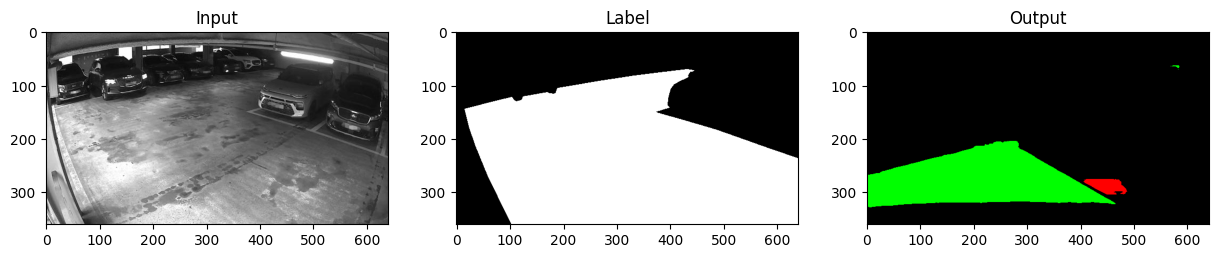

In [ ]:
import json
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

# 테스트 데이터셋에서 첫 번째 이미지와 레이블 로드
input_image = cv2.imread(test_dataset.input_paths[0], cv2.IMREAD_GRAYSCALE)

# JSON 파일 로드 및 레이블 배열 변환
with open(test_dataset.label_paths[0], 'r') as f:
    label_data = json.load(f)

label_image = np.zeros_like(input_image, dtype=np.uint8)

# 레이블 데이터에서 다각형 정보 추출 및 그리기
for region in label_data['segmentation']:
    label_name = region['name']
    points = np.array(region['polygon'], dtype=np.int32)

    # 클래스 할당 (0: Background, 1: Driveable Space, 2: Parking Space)
    if label_name == 'Driveable Space':
        cv2.fillPoly(label_image, [points], 1)
    elif label_name == 'Parking Space':
        cv2.fillPoly(label_image, [points], 2)

# 모델의 예측 결과 이미지 불러오기
output_image_path = os.path.join(result_dir, f'output_{base_filename}.png')
output_image = plt.imread(output_image_path)

# 시각화
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(input_image, cmap='gray')
plt.title('Input')

plt.subplot(1,3,2)
plt.imshow(label_image, cmap='gray')
plt.title('Label')

plt.subplot(1,3,3)
plt.imshow(output_image, cmap='gray')
plt.title('Output')

plt.show()

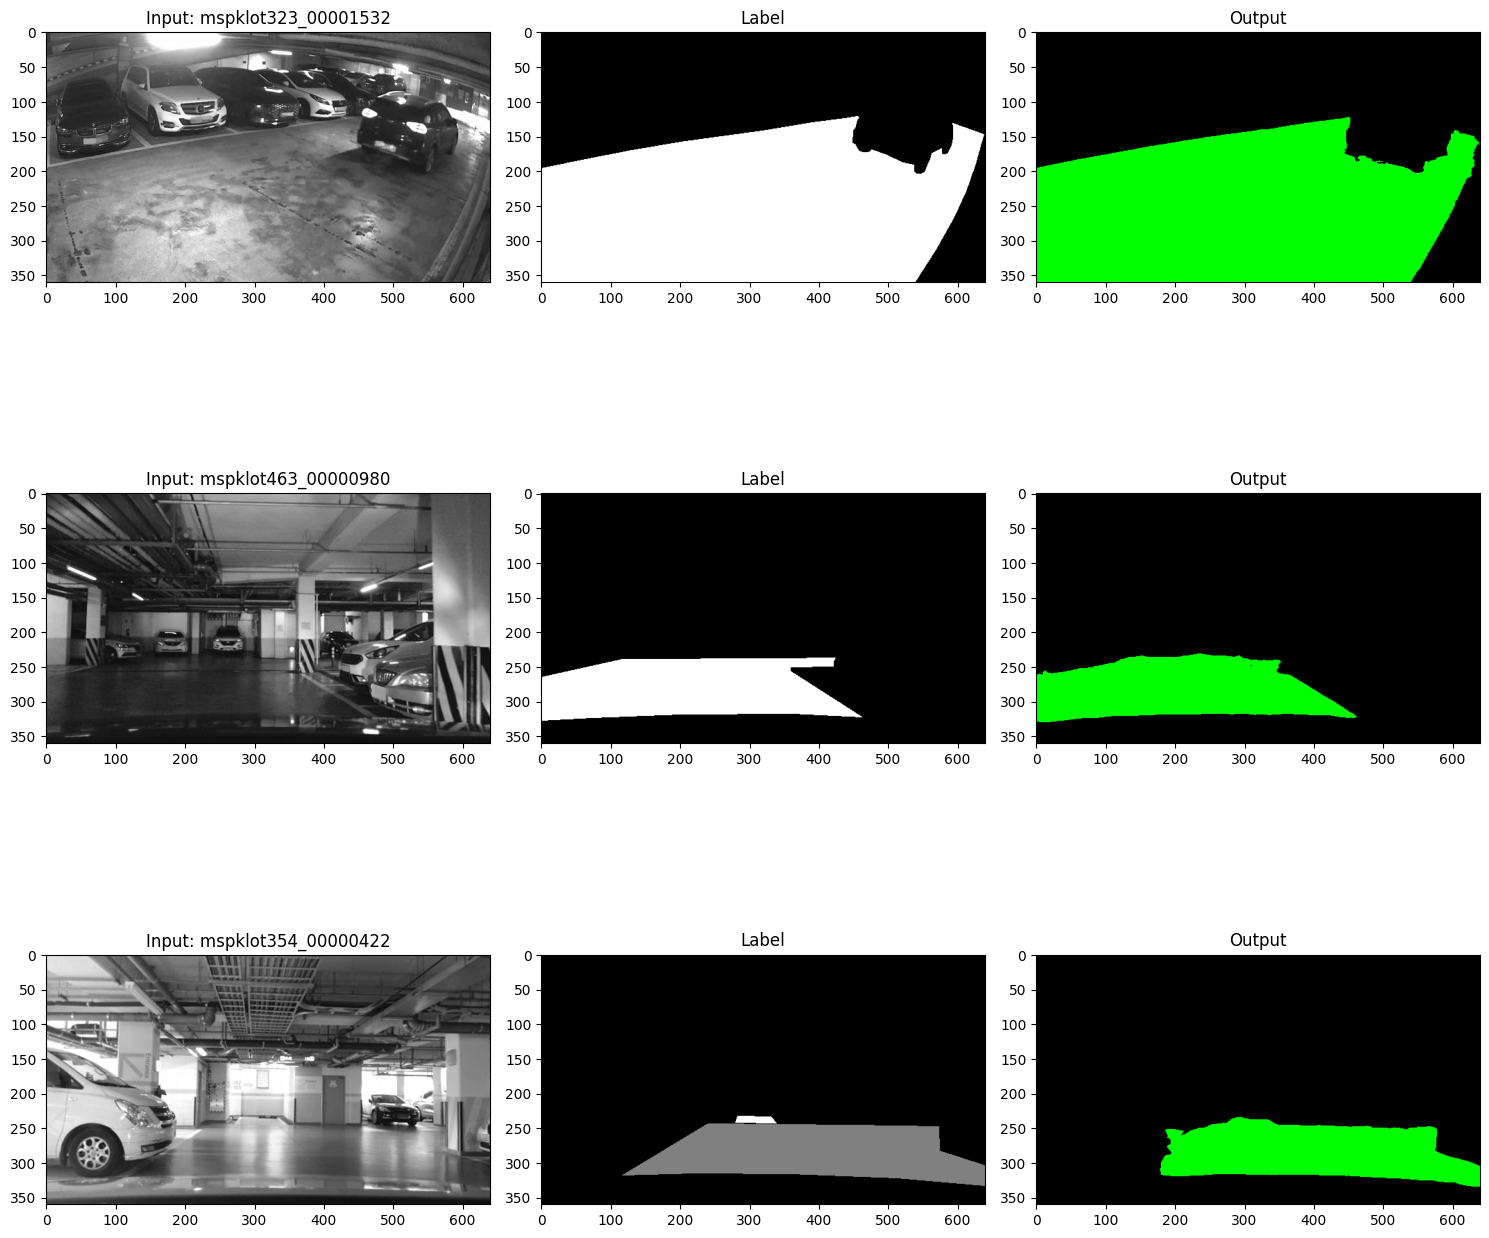

In [ ]:
import json
import numpy as np
import cv2
import os
import random
import matplotlib.pyplot as plt

# 랜덤하게 선택할 이미지 개수
num_samples = 3

# test 데이터셋에서 무작위로 인덱스를 선택
random_indices = random.sample(range(len(test_dataset)), num_samples)

plt.figure(figsize=(15, 5 * num_samples))

for i, idx in enumerate(random_indices):
    # 입력 이미지와 라벨 파일 경로
    input_image_path = test_dataset.input_paths[idx]
    label_path = test_dataset.label_paths[idx]

    # 입력 이미지 로드
    input_image = cv2.imread(input_image_path, cv2.IMREAD_GRAYSCALE)

    # JSON 파일 로드 및 라벨 배열 변환
    with open(label_path, 'r') as f:
        label_data = json.load(f)

    label_image = np.zeros_like(input_image, dtype=np.uint8)

    # 라벨 데이터에서 다각형 정보 추출 및 그리기
    for region in label_data['segmentation']:
        label_name = region['name']
        points = np.array(region['polygon'], dtype=np.int32)

        # 클래스 할당 (0: Background, 1: Driveable Space, 2: Parking Space)
        if label_name == 'Driveable Space':
            cv2.fillPoly(label_image, [points], 1)
        elif label_name == 'Parking Space':
            cv2.fillPoly(label_image, [points], 2)

    # 파일 이름에서 base 이름 추출
    original_filename = os.path.basename(input_image_path)
    base_filename, _ = os.path.splitext(original_filename)

    # 모델의 예측 결과 이미지 불러오기
    output_image_path = os.path.join(result_dir, f'output_{base_filename}.png')
    output_image = plt.imread(output_image_path)

    # 시각화
    plt.subplot(num_samples, 3, 3 * i + 1)
    plt.imshow(input_image, cmap='gray')
    plt.title(f'Input: {base_filename}')

    plt.subplot(num_samples, 3, 3 * i + 2)
    plt.imshow(label_image, cmap='gray')
    plt.title('Label')

    plt.subplot(num_samples, 3, 3 * i + 3)
    plt.imshow(output_image, cmap='gray')
    plt.title('Output')

plt.tight_layout()
plt.show()